In [1]:
import numpy as np

import pandas as pd
from sklearn import datasets

from sklearn.decomposition import PCA, FactorAnalysis

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adagrad, Adam

from sklearn.model_selection import train_test_split

from scipy.stats import spearmanr
from scipy.cluster import hierarchy

#from pylab import rcParams
#rcParams['figure.figsize'] = 14, 8
import seaborn as sns; 
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

RANDOM_SEED = 42

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files
uploaded = files.upload()

Saving shuttle.csv to shuttle.csv


In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import collections

# For plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [0]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.callbacks import EarlyStopping, ModelCheckpoint
import pydot as pyd

import keras.backend as K
from numpy.random import seed
seed(42)
keras.utils.vis_utils.pydot = pyd

In [0]:
df = pd.read_csv("shuttle.csv")
X = df.iloc[:, 0:-1].values
y=df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)
#print(X_train_scaled, X_test_scaled)


In [0]:
from keras.utils import plot_model

In [0]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [0]:

def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent subspace
    if (model_name == 'vae_mlp'):
        z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    else:
        z_mean = encoder.predict(x_test,batch_size=batch_size)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(np.amin(z_mean[:,0]), np.amax(z_mean[:,0]), n)
    grid_y = np.linspace(np.amin(z_mean[:,1]), np.amax(z_mean[:,1]), n)[::-1]

    z_sample = np.zeros((1,5))
    z_sample[0,2] = np.mean(z_mean[:,2])
    z_sample[0,3] = np.mean(z_mean[:,3])
    z_sample[0,4] = np.mean(z_mean[:,4])    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample[0,0] = xi
            z_sample[0,1] = yi
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 9)                 0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 88        
_________________________________________________________________
decoder (Model)              (None, 6)                 18        
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________


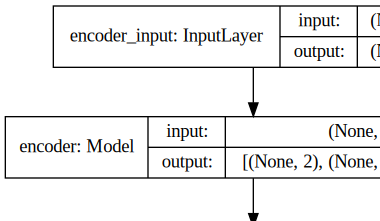

In [22]:
input_dim = X_scaled_train.shape[1]
batch_size = 128
latent_dim = 2
epochs = 20

#input_data = Input(shape=(input_dim,)) 
#encoder = Dense(units=6,activation='relu')(input_data)
#encoder = Dense(units=4,activation='relu')(encoder)
#encoder = Dense(units=2,activation='relu')(encoder)
#decoder = Dense(units=4,activation='relu')(encoder)
#decoder = Dense(units=6,activation='relu')(decoder)
#decoder = Dense(units=input_dim,activation='linear')(decoder)

#autoencoder = Model(input_data,decoder)



# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(input_dim,), name='encoder_input')

encoder = Dense(units=6,activation='relu')(inputs)
z_mean = Dense(latent_dim,activation='linear',name='z_mean')(encoder)
z_log_var = Dense(latent_dim, name='z_log_var',activation='relu')(encoder)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
#encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)



# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
outputs = Dense(units=6,activation='relu')(latent_inputs)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
#decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()
SVG(model_to_dot(vae, show_shapes='True').create(prog='dot', format='svg'))